1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [12]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [13]:
import pandas as pd # standard naming convention
import numpy as np
from numpy import random
#file name
file_name = "./data/data_000637.txt"
#to know the maximum number of rows
# rows : 1310720
#columns : 6
row_count, column_count = pd.read_csv(file_name).shape
#we choose N to be smaller or equal to row_count and larger than 10k
x = random.randint(10000, row_count+1) #row_count + 1 because can be equal to row_count
df = pd.read_csv(file_name,nrows=1310720)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [14]:
#we check the maximum value of 'BX_COUNTER' for every orbit before begin reset to 0
dfmax = df.groupby(['ORBIT_CNT'])['BX_COUNTER'].max()
print('Maximum value of bx before being reset to 0 :', dfmax.max()) #we print the maximum value

Maximum value of bx before being reset to 0 : 3563


3. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [15]:
time_counter = df['BX_COUNTER'] * 25 #we multiply by 25ns every bx_counter
time_counter = time_counter - time_counter[0] #we beging the data acquisition with the first value
time_meas = df['TDC_MEAS'] * 25/30 #we multiply by 25/20ns every tdc_meas
time_meas = time_meas - time_meas[0]
time_orbit = df['ORBIT_CNT'] * dfmax.max() * 25 #we multiply by x * 25ns every orbit_cnt 
time_orbit = time_orbit - time_orbit[0]
df['TIME'] = time_counter.cumsum() + time_meas.cumsum() + time_orbit.cumsum() #new column TIME
df['TIME'] = pd.to_timedelta(df['TIME'], unit="ns")#we convert the new column to a time series (since the begging of the data acquisition)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME
0,1,0,123,3869200167,2374,26,0 days 00:00:00
1,1,0,124,3869200167,2374,27,0 days 00:00:00
2,1,0,63,3869200167,2553,28,0 days 00:00:00.000004477
3,1,0,64,3869200167,2558,19,0 days 00:00:00.000009071
4,1,0,64,3869200167,2760,25,0 days 00:00:00.000018720
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,8 days 03:23:12.043346506
1310716,1,1,4,3869211171,763,11,8 days 03:23:13.023487519
1310717,1,0,64,3869211171,764,0,8 days 03:23:14.003628547
1310718,1,0,139,3869211171,769,0,8 days 03:23:14.983769700


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [16]:
#find the duration of the data
print(df['TIME'][len(df)-1] - df['TIME'][0])

8 days 03:23:15.963910694


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [17]:
#groupby(['TDC_CHANNEL'])['TDC_CHANNEL'].count() -> for every TDC_CHANNEL we count it
#we use .iloc[:3] to only print to screen the top 3 with the corresponding counts
df.groupby(['TDC_CHANNEL'])['TDC_CHANNEL'].count().sort_values(ascending=False).iloc[:3]


TDC_CHANNEL
139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [18]:
#drop_duplicates(keep='first') : we only keep the first instance of every orbits
#we count the orbits with at least one hit so the ones available in the data
df['ORBIT_CNT'].drop_duplicates(keep="first").count()

#or df.groupby['ORBIT_CNT'].count()

11001

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [19]:
df7 = df.loc[(df['TDC_CHANNEL'] == 139)]
#we select the datadrame where the TDC_CHANNEL = 139
#we do the same as the question 6 : we drop duplicate and we count the number of orbits with at least one measurement so the ones available in the data
df7['ORBIT_CNT'].drop_duplicates(keep="first").count() 

10976

8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [20]:
#Series for each FPGA
fpga0 = df[df['FPGA'] == 0].groupby(['TDC_CHANNEL'])['TDC_CHANNEL'].count()
fpga1 = df[df['FPGA'] == 1].groupby(['TDC_CHANNEL'])['TDC_CHANNEL'].count()

print("\nFPGA0 : \n",fpga0)
print("\nFPGA0 type : \n",type(fpga0))
print("\nFPGA0 index : \n",fpga0.index)

print("\nFPGA1 : \n",fpga1)
print("\nFPGA1 type : \n",type(fpga1))
print("\nFPGA1 index : \n",fpga1.index)


FPGA0 : 
 TDC_CHANNEL
1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Name: TDC_CHANNEL, Length: 124, dtype: int64

FPGA0 type : 
 <class 'pandas.core.series.Series'>

FPGA0 index : 
 Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            120, 121, 122, 123, 124, 129, 130, 137, 138, 139],
           dtype='int64', name='TDC_CHANNEL', length=124)

FPGA1 : 
 TDC_CHANNEL
1      28438
2      32669
3      21970
4      26403
5      15003
       ...  
129       35
130       38
137       36
138       36
139    32442
Name: TDC_CHANNEL, Length: 132, dtype: int64

FPGA1 type : 
 <class 'pandas.core.series.Series'>

FPGA1 index : 
 Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            123, 125, 126, 127, 128, 129, 130, 137, 138, 139],
           dtype='int64', name='TDC_CHANNEL', length=132)


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0.5, 0, 'TDC_CHANNEL')

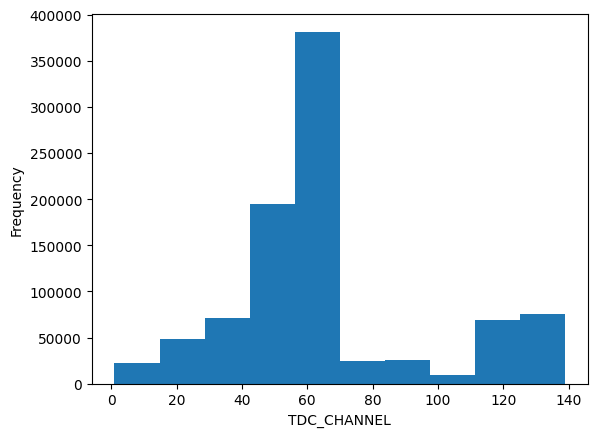

In [21]:
fpga0 = df[df['FPGA'] == 0]['TDC_CHANNEL']
hist0 = fpga0.plot(kind='hist')
hist0.set_xlabel('TDC_CHANNEL')

Text(0.5, 0, 'TDC_CHANNEL')

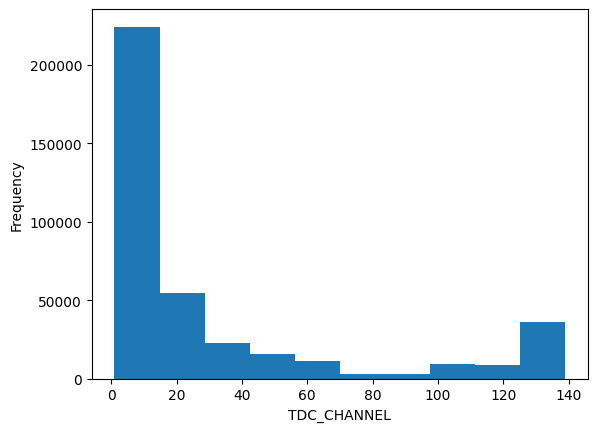

In [22]:
fpga1 = df[df['FPGA'] == 1]['TDC_CHANNEL']
hist1 = fpga1.plot(kind='hist')
hist1.set_xlabel('TDC_CHANNEL')